## LDA

LDA (linear discriminant analysis) is a classic linear classification method. Different from the idea of maximizing variance in PCA dimensionality reduction, the basic idea of LDA is to project the data into a low-dimensional space, so that the same type of data is as close as possible, and different types of data are as far apart as possible. So, LDA is a supervised linear classification algorithm.

<img src="1.png" />

Given data set $D=\{(x_{i}, y{i}) \}^{m}_{i=1}, \enspace y_{i} \in \{0,1\}$, and $X_{i}, \enspace \mu _{i}, \enspace \Sigma _{i}$ are the set, mean vector and covariance matrix of the $i$-th class of data.

Assuming that the above data is projected onto the straight line $w$, the projections of the centers of the two types of samples onto the straight line are $w^{\top}\mu _{0}$ and $w^{\top}\mu _{1}$, respectively. Considering all the sample projections, the covariances of the two types of samples are $w^{\top}\Sigma _{0} w$ and $w^{\top}\Sigma _{1} w$, respectively. Since the straight line $w$ is a one-dimensional space, the above values are all real numbers.

The optimization goals are to make the projection points of similar samples as close as possible, and the projection points of heterogeneous samples as far away as possible. 

To meet the first purpose, the covariance of the projection points of the similar sample need to be as small as possible, that is, $w^{\top}\Sigma _{0} w+w^{\top}\Sigma _{1} w$ as small as possible. The projection points of heterogeneous samples to be as far away as possible, which means the distance between the class center points to be as large as possible, that is, $||w^{\top}\mu _{0}-w^{\top}\mu _{1}||^{2}_{2}$ is as large as possible.

Considering these two optimization objectives at the same time, the objective function can be defined as:
$$
J=\frac{\left\|\boldsymbol{w}^{T} \boldsymbol{\mu}_{0}-\boldsymbol{w}^{T} \boldsymbol{\mu}_{1}\right\|_{2}^{2}}{\boldsymbol{w}^{T} \boldsymbol{\Sigma}_{0} \boldsymbol{w}+\boldsymbol{w}^{T} \boldsymbol{\Sigma}_{1} \boldsymbol{w}}=\frac{\boldsymbol{w}^{T}\left(\boldsymbol{\mu}_{0}-\boldsymbol{\mu}_{1}\right)\left(\boldsymbol{\mu}_{0}-\boldsymbol{\mu}_{1}\right)^{T} \boldsymbol{w}}{\boldsymbol{w}^{T}\left(\Sigma_{0}+\Sigma_{1}\right) \boldsymbol{w}}
$$

Define intra-class divergence matrix $S_w$ and between-class divergence matrix $S_b$:
$$
\begin{aligned}
&S_{w}=\Sigma _{0} + \Sigma _{1} \\
&S_{b}=(\mu _{0}-\mu _{1})(\mu _{0}-\mu _{1})^{\top}
\end{aligned}
$$

Then the objective function can be rewritten as:
$$
J = \frac{w^{\top}S_{b}w}{w^{\top}S_{w}w}
$$

The above formula is the ultimate optimization goal of LDA. To calculate $w$, $w^{\top}S_{w}w$can be set to be $1$, then the optimization formula can be expressed as:
$$
\min -w^{\top}S_{b}w \\
s.t. \enspace w^{\top}S_{w}w = 1
$$

According to Lagrange Multiplier Method for optimizing solution based on conditional constraints, the above formula is equal to:
$$
S_{b}w = \lambda S_{w}w
$$

Let $S_{b}w = \lambda (\mu _{0} - \mu _{1})$, and put it into the above formula:
$$
w = S^{-1}_{w}(\mu _{0} - \mu _{1})
$$

Considering the stability of the numerical solution of matrix $S_w$, singular value decomposition can be performed on it, that is:
$$
S_{w} = U\Sigma V^{\top}
$$

Finally, take its inverse to get $S_{w}^{-1}$, and use it to calculate $w$. The projected data points are $Y=S_{w}^{\top}X$.

In [1]:
import numpy as np

In [2]:
class LDA():
    def __init__(self):
        # initialize weight matrix
        self.w = None

    def calc_cov(self, X, Y=None):
        m = X.shape[0]
        # standardization
        X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
        Y = X if Y == None else (Y - np.mean(Y, axis=0))/np.std(Y, axis=0)
        return 1 / m * np.matmul(X.T, Y)

    def project(self, X, y):
        self.fit(X, y)
        X_projection = X.dot(self.w)
        return X_projection

    def fit(self, X, y):
        X0 = X[y == 0]
        X1 = X[y == 1]

        sigma0 = self.calc_cov(X0)
        sigma1 = self.calc_cov(X1)

        Sw = sigma0 + sigma1

        u0, u1 = np.mean(X0, axis=0), np.mean(X1, axis=0)
        mean_diff = np.atleast_1d(u0 - u1)

        U, S, V = np.linalg.svd(Sw)
        Sw_ = np.dot(np.dot(V.T, np.linalg.pinv(np.diag(S))), U.T)
        self.w = Sw_.dot(mean_diff)

    def predict(self, X):
        y_pred = []
        for sample in X:
            h = sample.dot(self.w)
            y = 1 * (h < 0)
            y_pred.append(y)
        return y_pred

In [3]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = datasets.load_iris()
X = data.data
y = data.target

X = X[y != 2]
y = y[y != 2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80, 4) (20, 4) (80,) (20,)


In [4]:
lda = LDA()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.85


In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def calculate_covariance_matrix(self, X, Y=None):
        m = X.shape[0]
        # standardization
        X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
        Y = X if Y == None else (Y - np.mean(Y, axis=0))/np.std(Y, axis=0)
        return 1 / m * np.matmul(X.T, Y)

    def _transform(self, X, dim):
        covariance = self.calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed

    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()

    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('class 1')
        plt.ylabel('class 2')

        plt.show()

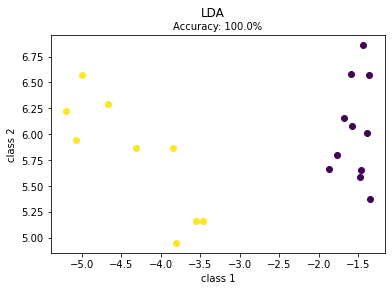

In [9]:
Plot().plot_in_2d(X_test, y_pred, title="LDA", accuracy=accuracy)

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0
